In [1]:
# Dataset information
"""
No: row number
year: year of data in this row
month: month of data in this row
day: day of data in this row
hour: hour of data in this row
PM2.5: PM2.5 concentration (ug/m^3)
PM10: PM10 concentration (ug/m^3)
SO2: SO2 concentration (ug/m^3)
NO2: NO2 concentration (ug/m^3)
CO: CO concentration (ug/m^3)
O3: O3 concentration (ug/m^3)
TEMP: temperature (degree Celsius)
PRES: pressure (hPa)
DEWP: dew point temperature (degree Celsius)
RAIN: precipitation (mm)
wd: wind direction
WSPM: wind speed (m/s)
station: name of the air-quality monitoring site
"""


'\nNo: row number\nyear: year of data in this row\nmonth: month of data in this row\nday: day of data in this row\nhour: hour of data in this row\nPM2.5: PM2.5 concentration (ug/m^3)\nPM10: PM10 concentration (ug/m^3)\nSO2: SO2 concentration (ug/m^3)\nNO2: NO2 concentration (ug/m^3)\nCO: CO concentration (ug/m^3)\nO3: O3 concentration (ug/m^3)\nTEMP: temperature (degree Celsius)\nPRES: pressure (hPa)\nDEWP: dew point temperature (degree Celsius)\nRAIN: precipitation (mm)\nwd: wind direction\nWSPM: wind speed (m/s)\nstation: name of the air-quality monitoring site\n'

In [2]:
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
from pandas import datetime as pd_datetime
from pandas import to_datetime
from numpy import nan as npnan
#dateparse = lambda x: pd_datetime.strptime(x, '%Y-%m-%d')
df = read_csv('data/PRSA_Data_Aotizhongxin_20130301-20170228.csv')
df['datetime'] = df['year'].astype('str') + "-" + df['month'].astype('str') + "-" + df['day'].astype('str')
df['datetime'] = to_datetime(df['datetime'])

df.set_index('datetime', inplace=True)
df.drop(['No','year','month','day','hour','station'],axis=1,inplace=True)
df.replace('nan',npnan)
df.dropna(axis=0,inplace=True)
df.head()

PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN  \
datetime                                                                     
2013-03-01    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0   
2013-03-01    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0   
2013-03-01    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0   
2013-03-01    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0   
2013-03-01    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0   

             wd  WSPM  
datetime               
2013-03-01  NNW   4.4  
2013-03-01    N   4.7  
2013-03-01  NNW   5.6  
2013-03-01   NW   3.1  
2013-03-01    N   2.0

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]

fig = plt.figure()

for i in range(1,13):
  try:
    plt.subplot(12,1,i)
    plt.plot(df.index,df[df.columns[i-1]])
    plt.title(df.columns[i-1])
  except TypeError:
    pass



plt.show()

In [6]:
dataset = df.copy()
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,10] = encoder.fit_transform(values[:,10])
# ensure all data is float
values = values.astype('float32')
print(values)
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 12
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
print(dataset.head())
reframed.head()

[[ 4.   4.   4.  ...  0.   6.   4.4]
 [ 8.   8.   4.  ...  0.   3.   4.7]
 [ 7.   7.   5.  ...  0.   6.   5.6]
 ...
 [16.  37.  10.  ...  0.   7.   1.1]
 [21.  44.  12.  ...  0.   6.   1.2]
 [19.  31.  10.  ...  0.   5.   1.3]]
(31812, 48)
            PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  DEWP  RAIN  \
datetime                                                                     
2013-03-01    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0 -18.8   0.0   
2013-03-01    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2 -18.2   0.0   
2013-03-01    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5 -18.2   0.0   
2013-03-01    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5 -19.4   0.0   
2013-03-01    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2 -19.5   0.0   

             wd  WSPM  
datetime               
2013-03-01  NNW   4.4  
2013-03-01    N   4.7  
2013-03-01  NNW   5.6  
2013-03-01   NW   3.1  
2013-03-01    N   2.0  


var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var6(t-3)  \
3   0.001408   0.002114   0.015010   0.017361   0.020202   0.181619   
4   0.007042   0.006342   0.015010   0.017361   0.020202   0.181619   
5   0.005634   0.005285   0.019388   0.027778   0.020202   0.172158   
6   0.004225   0.004228   0.045654   0.031250   0.020202   0.169792   
7   0.000000   0.001057   0.050032   0.034722   0.020202   0.169792   

   var7(t-3)  var8(t-3)  var9(t-3)  var10(t-3)  ...   var3(t)   var4(t)  \
3   0.280977   0.661318   0.258621         0.0  ...  0.045654  0.031250   
4   0.273997   0.664885   0.268025         0.0  ...  0.050032  0.034722   
5   0.273997   0.670231   0.268025         0.0  ...  0.076299  0.055556   
6   0.268761   0.688057   0.249216         0.0  ...  0.076299  0.104167   
7   0.258290   0.700533   0.247649         0.0  ...  0.080676  0.135417   

    var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  var10(t)  var11(t)  \
3  0.020202  0.169792  0.268761  0.688057  0.249216       0.0  0.466667   
4  0.020202  0.169792  0.258290  0.700533  0.247649       0.0  0.200000   
5  0.030303  0.155601  0.254799  0.707664  0.246082       0.0  0.200000   
6  0.040404  0.117757  0.247818  0.723707  0.253918       0.0  0.333333   
7  0.040404  0.101200  0.265270  0.739750  0.253918       0.0  0.400000   

   var12(t)  
3  0.276786  
4  0.178571  
5  0.330357  
6  0.223214  
7  0.339286  

[5 rows x 48 columns]

In [7]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 36) 8760 (8760,)
(8760, 3, 12) (8760,) (23052, 3, 12) (23052,)


In [8]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), shuffle=False)


Train on 8760 samples, validate on 23052 samples
Epoch 1/50
8760/8760 [==============================] - 1s 136us/step - loss: 0.0497 - val_loss: 0.0296
Epoch 2/50
8760/8760 [==============================] - 1s 107us/step - loss: 0.0309 - val_loss: 0.0263
Epoch 3/50
8760/8760 [==============================] - 1s 107us/step - loss: 0.0273 - val_loss: 0.0247
Epoch 4/50
8760/8760 [==============================] - 1s 110us/step - loss: 0.0253 - val_loss: 0.0232
Epoch 5/50
8760/8760 [==============================] - 1s 100us/step - loss: 0.0232 - val_loss: 0.0232
Epoch 6/50
8760/8760 [==============================] - 1s 105us/step - loss: 0.0215 - val_loss: 0.0221
Epoch 7/50
8760/8760 [==============================] - 1s 108us/step - loss: 0.0202 - val_loss: 0.0231
Epoch 8/50
8760/8760 [==============================] - 1s 108us/step - loss: 0.0194 - val_loss: 0.0227
Epoch 9/50
8760/8760 [==============================] - 1s 108us/step - loss: 0.0191 - val_loss: 0.0215
Epoch 10/50
87

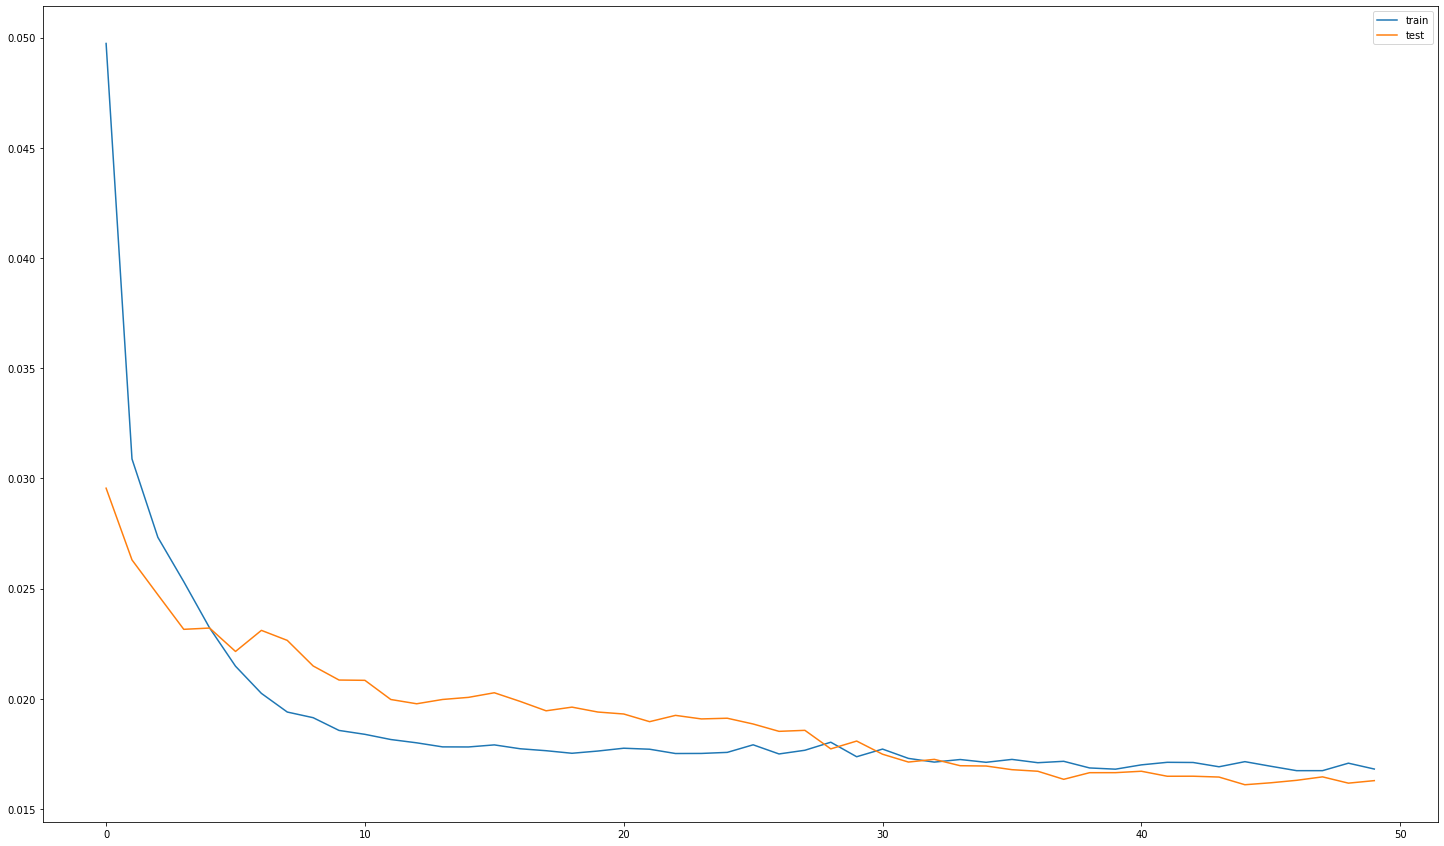

In [9]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [10]:
# make a prediction
yhat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], n_hours*n_features))
print(yhat.shape)
print(test_X.shape)
print(test_X_reshaped.shape)

(23052, 1)
(23052, 3, 12)
(23052, 36)


In [11]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_reshaped[:, -n_features+1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]


In [12]:
# invert scaling for actual
test_y_reshaped = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_reshaped, test_X_reshaped[:, -n_features+1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 20.514


In [14]:
training_df = DataFrame({'Train':dataset['PM2.5'][0:n_train_hours],'Actual':npnan, 'Forecast':npnan},index=dataset.index[0:n_train_hours])
predictions_df = DataFrame({'Train':npnan,'Actual':inv_y, 'Forecast':inv_yhat},index=dataset.index[n_train_hours+n_hours:])

pyplot.rcParams['figure.figsize'] = [25, 10]
plot_predictions = concat([training_df,predictions_df])
plot_predictions.index = to_datetime(plot_predictions.index)
plot_predictions.resample(rule='1D').mean().plot()